In [6]:
%load_ext  autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('..')

In [8]:
import os
import math

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import groupby
from IPython.display import display, HTML

from trickster.search import a_star_search
from trickster.wfp_helper import extract, load_cell, onehot, pad_and_onehot, reverse_onehot

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LinearRegression
from sklearn.svm import SVC
from scipy.spatial import distance
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from defaultcontext import with_default_context
from profiled import Profiler, profiled

seed = 2018

In [9]:
def load_data(path='./data/wfp_traces/'):
    labels = []
    data = []
    for fn in tqdm_notebook(os.listdir(path)):
        file_path = path + fn
        if os.path.isfile(file_path):
            cell_list = load_cell(file_path, max_len=5000)
            if "-" in str(fn):
                labels.append(1)
                data.append(cell_list)
            else:
                labels.append(0)
                data.append(cell_list)
        
    labels = np.array(labels)
    data = np.array(data)
    return data, labels

# Load data

Load website cell traces - load both cell traces.

In [10]:
X, y = load_data(path='./data/wfp_traces/')

trace_len, X = pad_and_onehot(X)
print("Shape of data: {}, Shape of labels: {}".format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=seed)
X_test, X_adv_test, y_test, y_adv_test = train_test_split(X_test, y_test, test_size=0.01, random_state=seed)

print("Number train samples: {}, Number test samples: {}".format(X_train.shape[0], X_test.shape[0]))

Shape of data: (18000, 15600), Shape of labels: (18000,)
Number train samples: 3600, Number test samples: 14256


# Fit models

In [11]:
# Fit logistic regression
logr_clf = LogisticRegression(random_state=seed, n_jobs=-1)
if not os.path.exists('./data/logr_linear.model'):
    logr_clf.fit(X_train, y_train)
    with open('./data/logr_linear.model','wb') as f:
        pickle.dump(logr_clf, f)
else:
    with open('./data/logr_linear.model','rb') as f:
        logr_clf = pickle.load(f)

svm_clf = SVC(random_state=seed, kernel='linear', probability=True)
if not os.path.exists('./data/svm_linear.model'):
    svm_clf.fit(X_train, y_train)
    with open('./data/svm_linear.model','wb') as f:
        pickle.dump(svm_clf, f)
else:
    with open('./data/svm_linear.model','rb') as f:
        svm_clf = pickle.load(f)

linr_clf = LogisticRegression(random_state=seed, n_jobs=-1)
if not os.path.exists('./data/linear_regression.model'):
    linr_clf.fit(X_train, y_train)
    with open('./data/linear_regression.model','wb') as f:
        pickle.dump(linr_clf, f)
else:
    with open('./data/linear_regression.model','rb') as f:
        linr_clf = pickle.load(f)

print('Logistic Regression Test score is: {:.2f}%.'.format(logr_clf.score(X_test, y_test)*100))
print('SVM Test score is: {:.2f}%.'.format(svm_clf.score(X_test, y_test)*100))
print('Linear Regression Test score is: {:.2f}%.'.format(linr_clf.score(X_test, y_test)*100))

Logistic Regression Test score is: 94.77%.
SVM Test score is: 91.61%.
Linear Regression Test score is: 94.77%.


In [12]:
@with_default_context(use_empty_init=True)
class Counter:
    def __init__(self):
        self.cnt = 0
        
    def increment(self):
        self.cnt += 1
        
    def count(self):
        return self.cnt

Define `Node` class transformation code:   
`weight_beginning` and `weight_bursts` decide to prioritise the start of a trace and large bursts, respectively, when choosing where to insert a new request.  
`children_num` spawns a number of children.  
`pad_requests` inserts a number of consecutive requests at a chosen index.

In [13]:
class Node:
    
    def __init__(self, x, weight_beginning=True, weight_bursts=True, children_num=1, pad_requests=3):
        self.root = list(reverse_onehot(x, trace_len))
        self.weight_beginning = weight_beginning
        self.weight_bursts = weight_bursts
        self.children_num = children_num 
        self.pad_requests = pad_requests 

    def _get_burst_arr(self, x):
        """Get an array of all bursts in cell trace.
           Return array with rows [idx0, idx1, len]
           idx0 : index of start of burst
           idx1 : index of end of burst
           len : length of burst
        """
        iszero = np.concatenate(([0], np.equal(x, -1).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        ranges_size = np.array([(x[0], x[1], x[1]-x[0]) for x in ranges])
        return ranges_size
    
    def _get_random_burst(self, bursts):
       
        if self.weight_beginning and not self.weight_bursts:
            bursts = bursts[bursts[:,0].argsort()]
            weight_arr = np.linspace(0.01, 0.99, num=bursts.shape[0])[::-1]
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)
        
        elif not self.weight_beginning and self.weight_bursts:
            bursts = bursts[bursts[:,2].argsort()]
            weight_arr = np.linspace(0.01, 0.99, num=bursts.shape[0])[::-1]
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)

        elif self.weight_beginning and self.weight_bursts:
            weight_arr = np.array([x[1]/float(x[0])-1 for x in bursts])
            weight_arr /= sum(weight_arr)
            index = np.random.choice(bursts.shape[0], p=weight_arr)

        else:
            index = np.random.randint(bursts.shape[0])
        
        return bursts[index]
    
    def expand(self):
        # Increment the counter of expanded nodes.
        counter = Counter.get_default()
        counter.increment()

        children = [ ]

        for i in range(self.children_num):
            bursts = self._get_burst_arr(self.root)
            burst = self._get_random_burst(bursts)
            new_request_idx = int(burst[0]) + int(burst[2]/ 2)
            expanded_node = self.root[:new_request_idx] + [1]*self.pad_requests + self.root[new_request_idx:]
            children.append(np.array(expanded_node)[:trace_len])
        
        return onehot(children)
    
    def __repr__(self):
        return 'Node({})'.format(self.root)

All the functions that need to be passed into the search, in the expected format.

In [14]:
def _expand_fn(x, p_norm=np.inf, **kwargs):
    """Wrap the example in `Node`, expand the node, and compute the costs.
    
    Returns a list of tuples (child, cost)
    """
    node = Node(x, **kwargs)
    children = node.expand()
    #costs = [np.linalg.norm(
    #    np.array(reverse_onehot(x, trace_len)) - np.array(reverse_onehot(c, trace_len)), ord=p_norm)
    #         for c in children]
    costs = [np.linalg.norm(c - x, ord=p_norm) for c in children]
    return list(zip(children, costs))

def _goal_fn(x, clf, target_confidence=0.5):
    """Tell whether the example has reached the goal."""
    return clf.predict_proba([x])[0, 1] >= target_confidence

def _heuristic_fn(x, clf, q_norm=np.inf):
    """Distance to the decision boundary of a logistic regression classifier.
    
    By default the distance is w.r.t. L1 norm. This means that the denominator
    has to be in terms of the Holder dual norm (`q_norm`), so L-inf. I know,
    this interface is horrible.
    
    NOTE: The value has to be zero if the example is already on the target side
    of the boundary.
    """
    score = clf.decision_function([x])[0]
    if score >= 0:
        return 0.0
    return np.abs(score) / np.linalg.norm(clf.coef_, ord=q_norm)

def hash_fn(x):
    """Hash function for examples."""
    x_str = ''.join(str(e) for e in x)
    return hash(x_str)

In [15]:
@profiled
def find_adversarial(x, clf, p_norm=np.inf, q_norm=np.inf,
                     target_confidence=0.5, return_path=False, **kwargs):
    """Transform an example until it is classified with target confidence.""" 

    if clf.predict_proba([x])[0, 1] >= target_confidence:
        raise Exception('Initial example is already classified as positive.')        
    return a_star_search(
        start_node=x, 
        expand_fn=lambda x: _expand_fn(x, p_norm=p_norm, **kwargs), 
        goal_fn=lambda x: _goal_fn(x, clf, target_confidence), 
        heuristic_fn=lambda x: _heuristic_fn(x, clf, q_norm=q_norm), 
        iter_lim=int(1e4),
        hash_fn=hash_fn,
        return_path=return_path
    )

In [16]:
def find_adv_examples(X, target_confidence,
                      graph='weight_none', children_num=3, pad_requests=3,
                      q_norm=np.inf, clf=svm_clf):
    """Find adversarial examples for a whole dataset"""
    
    if graph == 'weight_all':
        node_kwargs = dict(weight_beginning=True, weight_bursts=True, children_num=children_num, pad_requests=pad_requests)
    if graph == 'weight_bursts':
        node_kwargs = dict(weight_beginning=False, weight_bursts=True, children_num=children_num, pad_requests=pad_requests)
    if graph == 'weight_none':
        node_kwargs = dict(weight_beginning=False, weight_bursts=False, children_num=children_num, pad_requests=pad_requests)
 
    # Dataframe for storing the results.
    results = pd.DataFrame(
        columns=['index', 'found', 'confidence', 'original_confidence',
                 'real_cost', 'path_cost', 'nodes_expanded', 'runtime', 'conf_level'])

    # Indices of examples classified as negative.
    neg_indices, = np.where(clf.predict_proba(X)[:, 1] < target_confidence)
    
    samples = []
    
    for i, original_index in enumerate(neg_indices):
        x = X[original_index]
        
        # Instantiate a counter for expanded nodes, and a profiler.
        expanded_counter = Counter()
        per_example_profiler = Profiler()
        
        with expanded_counter.as_default(), per_example_profiler.as_default():
            x_adv, path_cost = find_adversarial(
                    x, clf, target_confidence=target_confidence, **node_kwargs)

        nodes_expanded = expanded_counter.count()
        runtime = per_example_profiler.compute_stats()['find_adversarial']['tot']
        
        # If an adversarial example was not found, only record index, runtime, and 
        # the number of expanded nodes.
        if x_adv is None:
            results.loc[i] = [original_index, False, [], None,
                              None, None, nodes_expanded, runtime, target_confidence]
            
        else:
            confidence = clf.predict_proba([x_adv])[0, 1]
            original_confidence = clf.predict_proba([x])[0, 1]
            real_cost = np.linalg.norm(reverse_onehot(x_adv, trace_len), ord=1) - np.linalg.norm(reverse_onehot(x, trace_len), ord=1)
            
            results.loc[i] = [original_index, True, confidence, original_confidence,
                              real_cost, path_cost, nodes_expanded, runtime, target_confidence]
            samples.append((x,x_adv))

    return results, samples

## Run the experiments  
  
Fix several target confidence levels.

In [17]:
confidence_levels = np.linspace(0.50, 0.75, 2)

Find adversarial examples for the whole dataset using different transformation graphs

In [18]:
from collections import defaultdict

clfs = [logr_clf, svm_clf, linr_clf]

wall_results = defaultdict(list)

logr_advs_wall, svm_advs_wall, linr_advs_wall = [], [], []
results_graph_logr_wall, results_graph_svm_wall, results_graph_linr_wall = [], [], []

for i, clf in enumerate(clfs):
    for level in tqdm_notebook(confidence_levels):
        results, samples = find_adv_examples(X_adv_test, level, graph='weight_all', clf=clf)
        if i == 0:
            wall_results['logr_advs_wall_%s' %level].append(samples)
            wall_results['logr_results_graph_wall_%s' %level].append(results)
        elif i == 1:
            wall_results['svm_advs_wall_%s' %level].append(samples)
            wall_results['svm_results_graph_wall_%s' %level].append(results)
        elif i == 2:
            wall_results['linr_advs_wall_%s' %level].append(samples)
            wall_results['linr_results_graph_wall_%s' %level].append(results)

for level in tqdm_notebook(confidence_levels):
    for i, results_graph in enumerate([wall_results['logr_results_graph_wall_%s' %level], 
                                       wall_results['svm_results_graph_wall_%s' %level], 
                                       wall_results['linr_results_graph_wall_%s' %level]]):
        for res in results_graph:
            if i == 0:
                print("Logistic Regression, target confidence %s" %level)
            elif i == 1:
                print("SVM, target confidence %s" %level)
            elif i == 2:
                print("Linear Regression, target confidence %s" %level)
            display(HTML(res.to_html()))
            print()
    

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


Logistic Regression, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.608181,7.814555e-06,15.0,5.0,176,3.943018,0.5
1,7,True,0.575432,5.299883e-06,9.0,3.0,17,0.360307,0.5
2,8,True,0.907120,5.832018e-04,3.0,1.0,3,0.067285,0.5
3,11,True,0.821921,1.723801e-04,6.0,2.0,9,0.234799,0.5
4,12,True,0.601472,1.860654e-07,9.0,3.0,13,0.288499,0.5
5,13,True,0.523106,3.748229e-04,12.0,4.0,48,1.211152,0.5
6,14,True,0.685845,1.105541e-04,9.0,3.0,26,0.668832,0.5
7,16,True,0.632752,6.844455e-04,6.0,2.0,7,0.157159,0.5
8,18,True,0.505378,1.172905e-03,3.0,1.0,1,0.025472,0.5
9,20,True,0.903035,7.987705e-06,15.0,5.0,27,0.568526,0.5



SVM, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.506211,0.004779,12.0,4.0,89,6.354703,0.5
1,7,True,0.543756,0.000815,9.0,3.0,13,0.868144,0.5
2,8,True,0.907138,0.035144,3.0,1.0,1,0.137054,0.5
3,11,True,0.934464,0.018419,6.0,2.0,9,0.697396,0.5
4,12,True,0.750878,0.000149,9.0,3.0,20,1.511207,0.5
5,13,True,0.721732,0.071878,12.0,4.0,38,2.728280,0.5
6,14,True,0.949564,0.005168,6.0,2.0,7,0.540158,0.5
7,16,True,0.598095,0.005923,3.0,1.0,3,0.259567,0.5
8,18,True,0.622427,0.052002,3.0,1.0,2,0.165339,0.5
9,20,True,0.536435,0.002751,15.0,5.0,66,4.374878,0.5



Linear Regression, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.852470,7.814555e-06,18.0,6.0,459,12.891048,0.5
1,7,True,0.575863,5.299883e-06,12.0,4.0,33,0.897353,0.5
2,8,True,0.857528,5.832018e-04,6.0,2.0,4,0.105767,0.5
3,11,True,0.723839,1.723801e-04,6.0,2.0,2,0.057152,0.5
4,12,True,0.521332,1.860654e-07,9.0,3.0,14,0.391333,0.5
5,13,True,0.638295,3.748229e-04,9.0,3.0,15,0.389844,0.5
6,14,True,0.900009,1.105541e-04,3.0,1.0,2,0.059677,0.5
7,16,True,0.597698,6.844455e-04,3.0,1.0,1,0.033112,0.5
8,18,True,0.857359,1.172905e-03,9.0,3.0,14,0.394323,0.5
9,20,True,0.767002,7.987705e-06,15.0,5.0,123,3.165601,0.5



Logistic Regression, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.773556,7.81455e-06,15,5,157,3.711382,0.75
1,7,True,0.751142,5.29988e-06,15,5,59,1.376345,0.75
2,8,True,0.816601,0.000583202,6,2,5,0.121784,0.75
3,11,True,0.770097,0.00017238,9,3,27,0.628438,0.75
4,12,True,0.831026,1.86065e-07,12,4,28,0.676901,0.75
5,13,True,0.970459,0.000374823,12,4,41,0.960853,0.75
6,14,True,0.809619,0.000110554,12,4,58,1.416514,0.75
7,16,True,0.973004,0.000684446,9,3,21,0.486944,0.75
8,18,True,0.922337,0.0011729,9,3,16,0.393942,0.75
9,20,True,0.758829,7.9877e-06,15,5,77,1.746456,0.75



SVM, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.818628,0.004779,12.0,4.0,62,5.104888,0.75
1,7,True,0.755207,0.000815,9.0,3.0,33,2.520142,0.75
2,8,True,0.907138,0.035144,3.0,1.0,1,0.121893,0.75
3,11,True,0.934464,0.018419,6.0,2.0,10,0.840131,0.75
4,12,True,0.893916,0.000149,9.0,3.0,23,2.008200,0.75
5,13,True,0.861648,0.071878,6.0,2.0,8,0.741185,0.75
6,14,True,0.969976,0.005168,3.0,1.0,1,0.190501,0.75
7,16,True,0.858005,0.005923,9.0,3.0,17,1.398064,0.75
8,18,True,0.772035,0.052002,6.0,2.0,7,0.540129,0.75
9,20,True,0.877010,0.002751,15.0,5.0,53,3.757807,0.75



Linear Regression, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.869665,7.81455e-06,15,5,114,3.315515,0.75
1,7,True,0.986426,5.29988e-06,15,5,58,1.473774,0.75
2,8,True,0.858435,0.000583202,12,4,41,1.197311,0.75
3,11,True,0.784971,0.00017238,9,3,13,0.421988,0.75
4,12,True,0.868354,1.86065e-07,9,3,24,0.612619,0.75
5,13,True,0.948092,0.000374823,12,4,49,1.260477,0.75
6,14,True,0.923529,0.000110554,12,4,76,2.178360,0.75
7,16,True,0.987742,0.000684446,9,3,15,0.431119,0.75
8,18,True,0.75587,0.0011729,9,3,15,0.410749,0.75
9,20,True,0.840472,7.9877e-06,15,5,162,4.342274,0.75


In [19]:
clfs = [logr_clf, svm_clf, linr_clf]

wnone_results = defaultdict(list)

logr_advs_wnone, svm_advs_wnone, linr_advs_wnone = [], [], []
results_graph_logr_wnone, results_graph_svm_wnone, results_graph_linr_wnone = [], [], []

for i, clf in enumerate(clfs):
    for level in tqdm_notebook(confidence_levels):
        results, samples = find_adv_examples(X_adv_test, level, graph='weight_none', clf=clf)
        if i == 0:
            wnone_results['logr_advs_wnone_%s' %level].append(samples)
            wnone_results['logr_results_graph_wnone_%s' %level].append(results)
        elif i == 1:
            wnone_results['svm_advs_wnone_%s' %level].append(samples)
            wnone_results['svm_results_graph_wnone_%s' %level].append(results)
        elif i == 2:
            wnone_results['linr_advs_wnone_%s' %level].append(samples)
            wnone_results['linr_results_graph_wnone_%s' %level].append(results)

for level in tqdm_notebook(confidence_levels):
    for i, results_graph in enumerate([wnone_results['logr_results_graph_wnone_%s' %level], 
                                       wnone_results['svm_results_graph_wnone_%s' %level], 
                                       wnone_results['linr_results_graph_wnone_%s' %level]]):
        for res in results_graph:
            if i == 0:
                print("Logistic Regression, target confidence %s" %level)
            elif i == 1:
                print("SVM, target confidence %s" %level)
            elif i == 2: 
                print("Linear Regression, target confidence %s" %level)
            display(HTML(res.to_html()))
            print()

Logistic Regression, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.548285,7.81455e-06,18,6,634,17.085154,0.5
1,7,True,0.838206,5.29988e-06,9,3,31,0.759538,0.5
2,8,True,0.918708,0.000583202,12,4,30,0.795425,0.5
3,11,True,0.733502,0.00017238,6,2,10,0.238436,0.5
4,12,True,0.868105,1.86065e-07,21,7,1419,34.792203,0.5
5,13,True,0.682749,0.000374823,12,4,78,1.831608,0.5
6,14,True,0.558474,0.000110554,18,6,508,12.489991,0.5
7,16,True,0.566894,0.000684446,18,6,434,11.618312,0.5
8,18,True,0.667601,0.0011729,9,3,38,0.957953,0.5
9,20,True,0.601079,7.9877e-06,15,5,91,2.262562,0.5



SVM, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.708964,0.004779,15.0,5.0,178,12.881660,0.5
1,7,True,0.546029,0.000815,9.0,3.0,13,0.965464,0.5
2,8,True,0.925302,0.035144,6.0,2.0,9,0.710477,0.5
3,11,True,0.531710,0.018419,9.0,3.0,21,1.465641,0.5
4,12,True,0.519323,0.000149,18.0,6.0,461,33.688632,0.5
5,13,True,0.549641,0.071878,12.0,4.0,37,2.645999,0.5
6,14,True,0.930925,0.005168,15.0,5.0,157,11.586707,0.5
7,16,True,0.807331,0.005923,12.0,4.0,65,4.689934,0.5
8,18,True,0.778012,0.052002,9.0,3.0,26,1.925730,0.5
9,20,True,0.594914,0.002751,15.0,5.0,133,9.068967,0.5



Linear Regression, target confidence 0.5


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.810504,7.81455e-06,18,6,645,15.498955,0.5
1,7,True,0.711343,5.29988e-06,9,3,20,0.459603,0.5
2,8,True,0.840863,0.000583202,6,2,8,0.220470,0.5
3,11,True,0.833423,0.00017238,6,2,10,0.231747,0.5
4,12,True,0.862017,1.86065e-07,15,5,279,6.751718,0.5
5,13,True,0.569972,0.000374823,12,4,48,1.219730,0.5
6,14,True,0.673986,0.000110554,12,4,87,2.113718,0.5
7,16,True,0.974624,0.000684446,15,5,191,4.574620,0.5
8,18,True,0.690314,0.0011729,12,4,66,1.660595,0.5
9,20,True,0.671826,7.9877e-06,15,5,86,2.076382,0.5



Logistic Regression, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.841352,7.81455e-06,21,7,1725,39.988067,0.75
1,7,True,0.826933,5.29988e-06,18,6,389,8.891471,0.75
2,8,True,0.949338,0.000583202,12,4,40,0.948204,0.75
3,11,True,0.90805,0.00017238,12,4,34,0.744340,0.75
4,12,True,0.819011,1.86065e-07,18,6,905,20.960881,0.75
5,13,True,0.869824,0.000374823,15,5,225,5.170494,0.75
6,14,True,0.933842,0.000110554,15,5,184,4.265247,0.75
7,16,True,0.782299,0.000684446,21,7,979,22.636028,0.75
8,18,True,0.966874,0.0011729,12,4,83,1.897355,0.75
9,20,True,0.818516,7.9877e-06,15,5,160,3.669642,0.75



SVM, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.775813,0.0047789,18,6,420,30.536730,0.75
1,7,True,0.841041,0.000814584,12,4,57,4.119352,0.75
2,8,True,0.902043,0.0351437,9,3,37,2.694021,0.75
3,11,True,0.894268,0.0184189,12,4,44,3.046521,0.75
4,12,True,0.775185,0.00014946,12,4,70,5.157842,0.75
5,13,True,0.863666,0.0718776,9,3,39,2.919655,0.75
6,14,True,0.931285,0.00516787,15,5,199,14.579872,0.75
7,16,True,0.796211,0.00592285,12,4,69,5.084336,0.75
8,18,True,0.857725,0.0520021,9,3,34,2.411517,0.75
9,20,True,0.836088,0.00275089,15,5,225,15.564740,0.75



Linear Regression, target confidence 0.75


,index,found,confidence,original_confidence,real_cost,path_cost,nodes_expanded,runtime,conf_level
0,2,True,0.841033,7.81455e-06,24,8,3327,80.530220,0.75
1,7,True,0.801601,5.29988e-06,15,5,114,2.674555,0.75
2,8,True,0.869938,0.000583202,12,4,92,2.151242,0.75
3,11,True,0.827793,0.00017238,12,4,71,1.686650,0.75
4,12,True,0.764305,1.86065e-07,21,7,2168,52.378973,0.75
5,13,True,0.916613,0.000374823,12,4,82,1.957288,0.75
6,14,True,0.787657,0.000110554,12,4,48,1.175196,0.75
7,16,True,0.94001,0.000684446,12,4,108,2.595622,0.75
8,18,True,0.836522,0.0011729,12,4,61,1.393391,0.75
9,20,True,0.848574,7.9877e-06,21,7,1218,28.971601,0.75


Check path cost and real cost are correlated.

Target confidence:  0.5


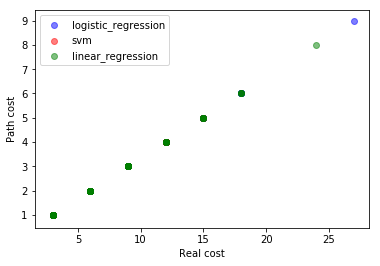

Target confidence:  0.75


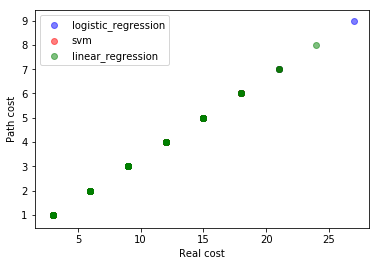

In [20]:
for level in tqdm_notebook(confidence_levels):
    print("Target confidence: ", level)
    for i, results_graph in enumerate([wall_results['logr_results_graph_wall_%s' %level], 
                                       wall_results['svm_results_graph_wall_%s' %level], 
                                       wall_results['linr_results_graph_wall_%s' %level]]):
        for res in results_graph:
            if i == 0:
                plt.scatter(res['real_cost'], res['path_cost'], color='blue', label='logistic_regression', alpha=0.5)
            elif i == 1:
                plt.scatter(res['real_cost'], res['path_cost'], color='red', label='svm', alpha=0.5)
            elif i == 2:
                plt.scatter(res['real_cost'], res['path_cost'], color='green', label='linear_regression', alpha=0.5)


    plt.xlabel('Real cost')
    plt.ylabel('Path cost')
    plt.legend(loc='best')
    plt.show()

Target confidence:  0.5


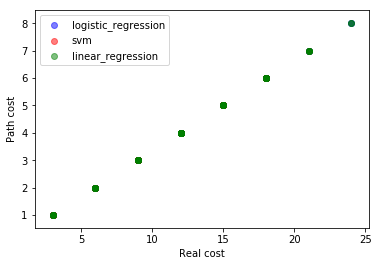

Target confidence:  0.75


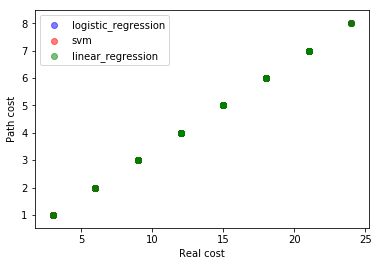

In [21]:
for level in tqdm_notebook(confidence_levels):
    print("Target confidence: ", level)
    for i, results_graph in enumerate([wnone_results['logr_results_graph_wnone_%s' %level], 
                                       wnone_results['svm_results_graph_wnone_%s' %level], 
                                       wnone_results['linr_results_graph_wnone_%s' %level]]):
        for res in results_graph:
            if i == 0:
                plt.scatter(res['real_cost'], res['path_cost'], color='blue', label='logistic_regression', alpha=0.5)
            elif i == 1:
                plt.scatter(res['real_cost'], res['path_cost'], color='red', label='svm', alpha=0.5)
            elif i == 2:
                plt.scatter(res['real_cost'], res['path_cost'], color='green', label='linear_regression', alpha=0.5)


    plt.xlabel('Real cost')
    plt.ylabel('Path cost')
    plt.legend(loc='best')
    plt.show()

## Sanity check for the optimality

This part was used for debugging. We claim it is more efficient to split larger bursts and insert requests at the beginningof a trace
rather than the end. The assumption is satisfied if the cost adversarial examples found under
`weight_beginning=True` and `weight_bursts=True` is smaller than the cost of adversarial examples found under
`weight_beginning=False` and `weight_bursts=False`

In [22]:
def example_diff(a, b):
    different_indices = np.where(a != b)
    return pd.DataFrame(
        [a[different_indices], b[different_indices]],
        columns=df_X.columns[different_indices],
    )

In [23]:
for level in tqdm_notebook(confidence_levels):
    print()
    print("Target confidence: ", level)
    print()
    results_graph_wall = [wall_results['logr_results_graph_wall_%s' %level], 
                          wall_results['svm_results_graph_wall_%s' %level], 
                          wall_results['linr_results_graph_wall_%s' %level]]
    results_graph_wnone = [wnone_results['logr_results_graph_wnone_%s' %level], 
                           wnone_results['svm_results_graph_wnone_%s' %level], 
                           wnone_results['linr_results_graph_wnone_%s' %level]]

    results_graph = list(zip(results_graph_wall, results_graph_wnone))

    for j, (result_graph_1, result_graph_2) in enumerate(results_graph):

        count = 0
        total_count = 0
        if j == 0:
            print("Logistic Regression")
        elif j == 1:
            print("SVM")
        elif j == 2:
            print("Linear Regression")

        for i, x in enumerate(X_test):
            total_count += 1
            a = result_graph_1[0]['path_cost'][result_graph_1[0]['index'] == i].values
            b = result_graph_2[0]['path_cost'][result_graph_2[0]['index'] == i].values

            try:
                if len(a) > 0 and len(b) > 0 and not pd.isna(a) and not pd.isna(b):
                    assert a[0] <= b[0]

            # Output information about violating examples.
            except AssertionError:

                count += 1

                continue

        print("Assumptions satisfy {:.3f}% of inputs.".format(100*(1-count/total_count)))
        print()


Target confidence:  0.5

Logistic Regression
Assumptions satisfy 99.944% of inputs.

SVM
Assumptions satisfy 99.986% of inputs.

Linear Regression
Assumptions satisfy 99.958% of inputs.


Target confidence:  0.75

Logistic Regression
Assumptions satisfy 99.930% of inputs.

SVM
Assumptions satisfy 99.944% of inputs.

Linear Regression
Assumptions satisfy 99.958% of inputs.



### Plots

Success rates for crafting adversarial examples, and average confidence of these.

In [24]:
def plot_confidence(results):
    a = [result['confidence'].as_matrix() for result in results]
    a = np.array([np.mean([z for z in x if isinstance(z,float)]) for x in a])
    a[np.isnan(a)] = 0
    avg_confidence = a
    
    success_prop = [result['found'].mean() for result in results]
    
    
    fig, ax = plt.subplots()
    ax.set_xticks(confidence_levels)
    ax.plot(confidence_levels, success_prop,
            label='Success proportion')
    ax.plot(confidence_levels, avg_confidence,
            label='Avg confidence of adversarial examples')
    ax.plot(confidence_levels, confidence_levels,
            linestyle='dashed', color='gray', label='Baseline confidence')
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('')
    plt.legend()
    plt.show()

Logistic Regression


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


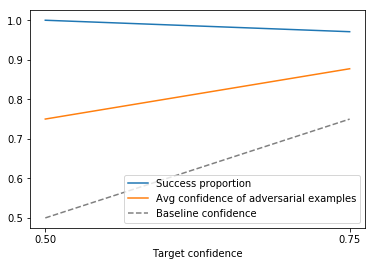

SVM


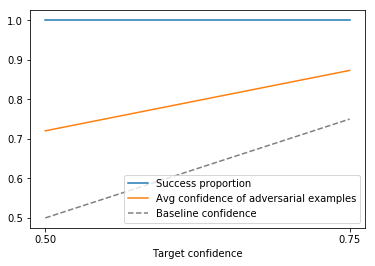

Linear Regression


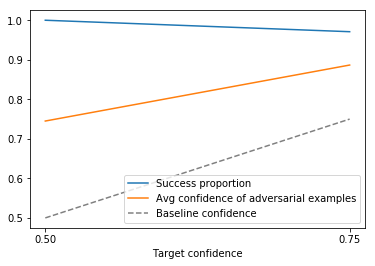

In [25]:
results_graph_logr_wall = []
results_graph_svm_wall = []
results_graph_linr_wall = []

for level in tqdm_notebook(confidence_levels):
    for i, results_graph in enumerate([wall_results['logr_results_graph_wall_%s' %level], 
                                       wall_results['svm_results_graph_wall_%s' %level], 
                                       wall_results['linr_results_graph_wall_%s' %level]]):
        if i == 0:
            results_graph_logr_wall.extend(results_graph)
        elif i == 1:
            results_graph_svm_wall.extend(results_graph)
        elif i == 2:
            results_graph_linr_wall.extend(results_graph)

print("Logistic Regression")
plot_confidence(results_graph_logr_wall)
print("SVM")
plot_confidence(results_graph_svm_wall)
print("Linear Regression")
plot_confidence(results_graph_linr_wall)

Logistic Regression


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


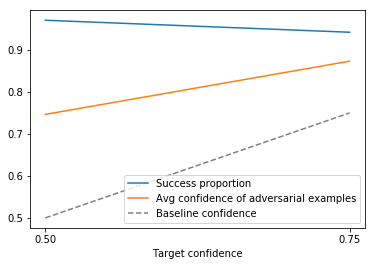

SVM


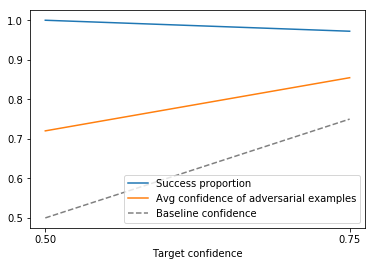

Linear Regression


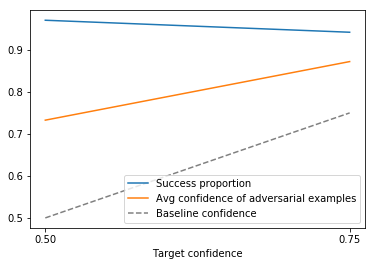

In [26]:
results_graph_logr_wnone = []
results_graph_svm_wnone = []
results_graph_linr_wnone = []

for level in tqdm_notebook(confidence_levels):
    for i, results_graph in enumerate([wnone_results['logr_results_graph_wnone_%s' %level], 
                                       wnone_results['svm_results_graph_wnone_%s' %level], 
                                       wnone_results['linr_results_graph_wnone_%s' %level]]):
        if i == 0:
            results_graph_logr_wnone.extend(results_graph)
        elif i == 1:
            results_graph_svm_wnone.extend(results_graph)
        elif i == 2:
            results_graph_linr_wnone.extend(results_graph)

print("Logistic Regression")
plot_confidence(results_graph_logr_wnone)
print("SVM")
plot_confidence(results_graph_svm_wnone)
print("Linear Regression")
plot_confidence(results_graph_linr_wnone)

Number of expanded nodes for graph 1 (strongly correlated with runtime)

Logistic Regression


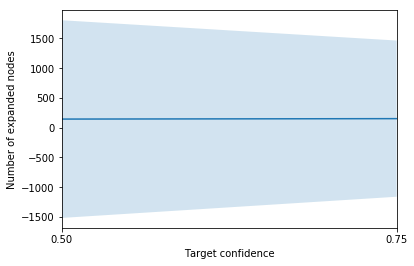

SVM


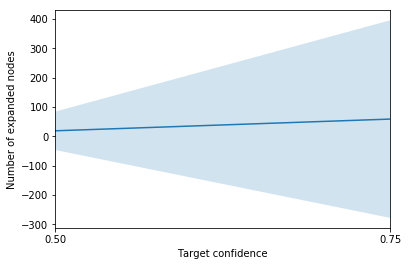

Linear Regression


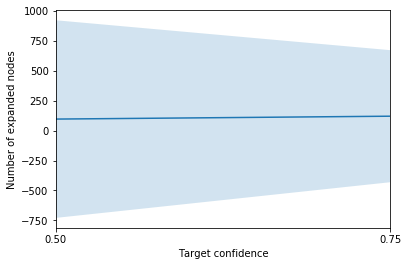

In [27]:
def expanded_nodes_plot(results):
    avg_expanded = pd.Series(
        [np.mean(result['nodes_expanded'][result['found']])
         for result in results])
    sigma_expanded = pd.Series(
        [np.std(result['nodes_expanded'][result['found']])
         for result in results])

    avg_runtime = pd.Series(
        [np.mean(result['runtime'][result['found']])
         for result in results])

    fig, ax = plt.subplots()
    avg_expanded.plot(label='Number of expanded nodes', ax=ax)
    ax.fill_between(range(len(confidence_levels)),
                    avg_expanded - 2 * sigma_expanded,
                    avg_expanded + 2 * sigma_expanded, alpha=.2)
    ax.set_xticks(range(len(confidence_levels)))
    ax.set_xticklabels(['%2.2f' % level for level in confidence_levels])
    ax.set_xlim(0, len(confidence_levels) - 1)
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('Number of expanded nodes')

    # avg_runtime.plot(secondary_y=True, label='Avg runtime')
    plt.show()
    
results_graph_logr_wnone = []
results_graph_svm_wnone = []
results_graph_linr_wnone = []

for level in tqdm_notebook(confidence_levels):
    for i, results_graph in enumerate([wnone_results['logr_results_graph_wnone_%s' %level], 
                                       wnone_results['svm_results_graph_wnone_%s' %level], 
                                       wnone_results['linr_results_graph_wnone_%s' %level]]):
        if i == 0:
            results_graph_logr_wnone.extend(results_graph)
        elif i == 1:
            results_graph_svm_wnone.extend(results_graph)
        elif i == 2:
            results_graph_linr_wnone.extend(results_graph)
    
print("Logistic Regression")
expanded_nodes_plot(results_graph_logr_wall)
print("SVM")
expanded_nodes_plot(results_graph_svm_wall)
print("Linear Regression")
expanded_nodes_plot(results_graph_linr_wall)

### Transferability

Note: As expected, transferability increases as target confidence increases,
      and weighted adversarial examples are more transferable than non-weighted ones.

In [33]:
from itertools import combinations

def get_accuracy(X_X_adv, clf, target_confidence=0.5):
    total_count = 0
    success_count = 0
    for _, x_adv in X_X_adv:
        total_count += 1
        adv_confidence = clf.predict_proba([x_adv])[0, 1] 
        if adv_confidence >= target_confidence:
            success_count += 1
    return success_count/float(total_count)

for level in tqdm_notebook(confidence_levels):
    print()
    print("Target confidence: ", level)
    print()
    
    adv_wall = [('logr_advs_wall', wall_results['logr_advs_wall_%s' %level], logr_clf), 
                ('svm_advs_wall', wall_results['svm_advs_wall_%s' %level], svm_clf), 
                ('linr_advs_wall', wall_results['linr_advs_wall_%s' %level], linr_clf)]
    adv_wnone = [('logr_advs_wnone', wnone_results['logr_advs_wnone_%s' %level], logr_clf), 
                 ('svm_advs_wnone', wnone_results['svm_advs_wnone_%s' %level], svm_clf), 
                 ('linr_advs_wnone', wnone_results['linr_advs_wnone_%s' %level], linr_clf)]

    adv_wall_combs = list(combinations(adv_wall, 2))
    adv_wnone_combs = list(combinations(adv_wnone, 2))


    # weight all transferability 
    for adv_w in [adv_wall_combs, adv_wnone_combs]:
        for (adv_1, adv_2) in adv_w:

            adv_1_name, adv_1_samples, clf_1 = adv_1[0], adv_1[1][0], adv_1[2]
            adv_2_name, adv_2_samples, clf_2 = adv_2[0], adv_2[1][0], adv_2[2]


            print()
            print("Transferability: ", adv_1_name, " --> ", adv_2_name)
            if len(adv_1_samples) == 0:
                print("No adversarial examples found using ", adv_1_name)
            else:
                clf_1_adv_1 = get_accuracy(adv_1_samples, clf_1)
                print("Adversarial success of %s adversarial examples on %s classifier: %.2f" %(adv_1_name, adv_1_name, clf_1_adv_1))
                clf_2_adv_1 = get_accuracy(adv_1_samples, clf_2)
                print("Adversarial success of %s adversarial examples on %s classifier: %.2f" %(adv_1_name, adv_2_name, clf_2_adv_1))









Target confidence:  0.5


Transferability:  logr_advs_wall  -->  svm_advs_wall
Adversarial success of logr_advs_wall adversarial examples on logr_advs_wall classifier: 1.00
Adversarial success of logr_advs_wall adversarial examples on svm_advs_wall classifier: 0.97

Transferability:  logr_advs_wall  -->  linr_advs_wall
Adversarial success of logr_advs_wall adversarial examples on logr_advs_wall classifier: 1.00
Adversarial success of logr_advs_wall adversarial examples on linr_advs_wall classifier: 1.00

Transferability:  svm_advs_wall  -->  linr_advs_wall
Adversarial success of svm_advs_wall adversarial examples on svm_advs_wall classifier: 1.00
Adversarial success of svm_advs_wall adversarial examples on linr_advs_wall classifier: 0.60

Transferability:  logr_advs_wnone  -->  svm_advs_wnone
Adversarial success of logr_advs_wnone adversarial examples on logr_advs_wnone classifier: 1.00
Adversarial success of logr_advs_wnone adversarial examples on svm_advs_wnone classifier: 0.91

Tra